In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> BiLSTM1 - BiGRU1 </h1>

In [10]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128, 256)          141312    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [11]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 13s 61ms/step - loss: 1.1128 - accuracy: 0.5283 - val_loss: 0.8234 - val_accuracy: 0.6668
Epoch 2/100
58/58 [==============================] - 2s 39ms/step - loss: 0.8654 - accuracy: 0.6404 - val_loss: 0.7821 - val_accuracy: 0.6804
Epoch 3/100
58/58 [==============================] - 2s 39ms/step - loss: 0.6208 - accuracy: 0.7349 - val_loss: 0.7066 - val_accuracy: 0.6985
Epoch 4/100
58/58 [==============================] - 2s 38ms/step - loss: 0.5636 - accuracy: 0.7580 - val_loss: 0.4241 - val_accuracy: 0.8218
Epoch 5/100
58/58 [==============================] - 2s 38ms/step - loss: 0.3496 - accuracy: 0.8664 - val_loss: 0.2683 - val_accuracy: 0.8935
Epoch 6/100
58/58 [==============================] - 2s 38ms/step - loss: 0.2103 - accuracy: 0.9218 - val_loss: 0.1694 - val_accuracy: 0.9261
Epoch 7/100
58/58 [==============================] - 2s 38ms/step - loss: 0.1662 - accuracy: 0.9351 - val_loss: 0.1317 - val_accuracy: 0.9465
Epoch

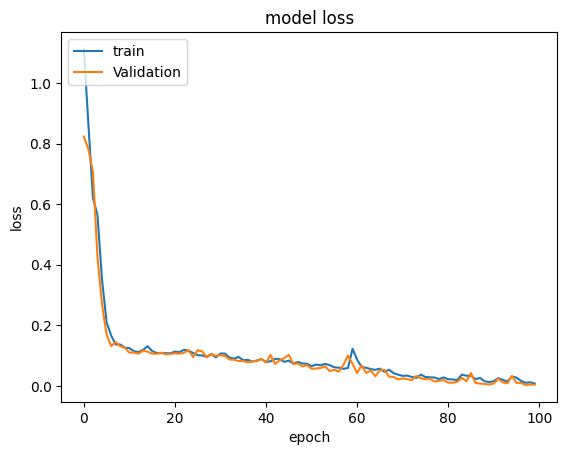

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

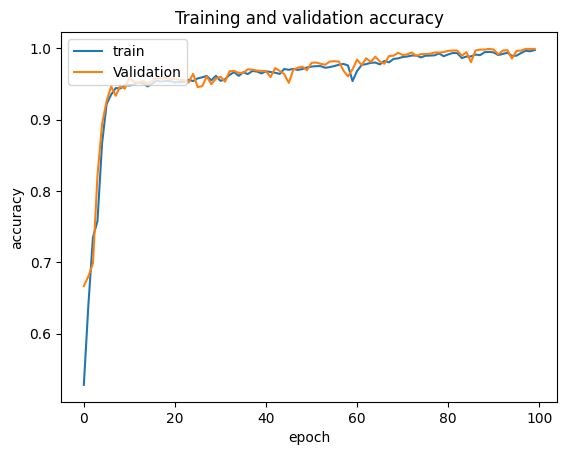

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 12ms/step
[[469   0  27   0   0   0]
 [ 39 411  21   0   0   0]
 [  3   8 409   0   0   0]
 [  0   2   0 448  36   5]
 [  1   0   0  17 514   0]
 [  0   0   0   0   0 537]]
0.9460468272819816
0.9458714317550382
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       496
           1       0.98      0.87      0.92       471
           2       0.89      0.97      0.93       420
           3       0.96      0.91      0.94       491
           4       0.93      0.97      0.95       532
           5       0.99      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.94      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

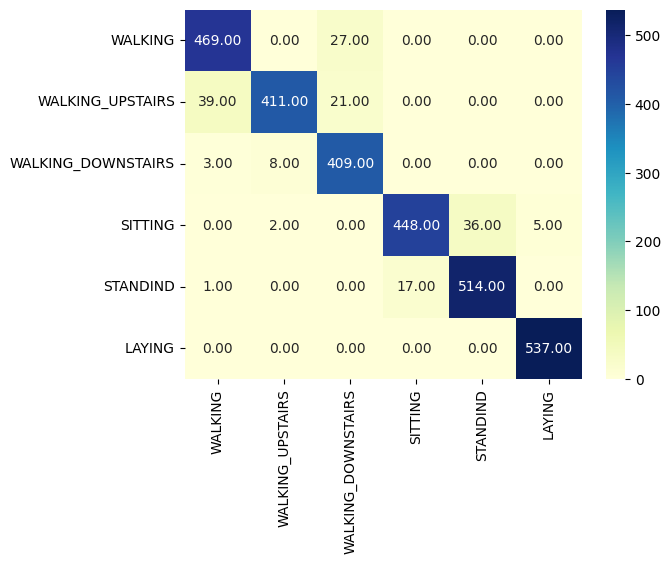

In [14]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU1 </h1>

In [15]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 15s 98ms/step - loss: 1.0574 - accuracy: 0.5516 - val_loss: 0.6850 - val_accuracy: 0.7217
Epoch 2/100
58/58 [==============================] - 4s 68ms/step - loss: 0.4974 - accuracy: 0.8079 - val_loss: 0.4555 - val_accuracy: 0.8024
Epoch 3/100
58/58 [==============================] - 4s 73ms/step - loss: 0.3297 - accuracy: 0.8747 - val_loss: 0.2819 - val_accuracy: 0.8989
Epoch 4/100
58/58 [==============================] - 4s 64ms/step - loss: 0.2447 - accuracy: 0.9085 - val_loss: 0.1595 - val_accuracy: 0.9343
Epoch 5/100
58/58 [==============================] - 4s 64ms/step - loss: 0.1600 - accuracy: 0.9378 - val_loss: 0.1267 - val_accuracy: 0.9529
Epoch 6/100
58/58 [==============================] - 4s 65ms/step - loss: 0.1630 - accuracy: 0.9399 - val_loss: 0.1460 - val_accuracy: 0.9474
Epoch 7/100
58/58 [==============================] - 4s 65ms/step - loss: 0.1458 - accuracy: 0.9436 - val_loss: 0.1115 - val_accuracy: 0.9578
Epoch

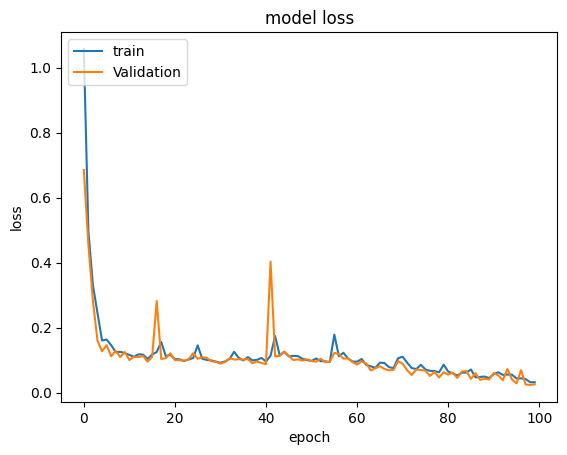

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

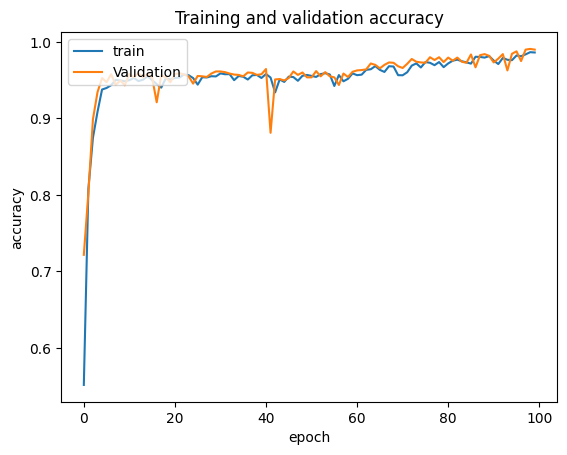

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 16ms/step
[[469   4  21   2   0   0]
 [ 18 431  19   3   0   0]
 [  0   0 420   0   0   0]
 [  0   2   0 377  89  23]
 [  1   0   0  16 515   0]
 [  0   0   0   0   0 537]]
0.9328130302002036
0.9315913904905506
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       496
           1       0.99      0.92      0.95       471
           2       0.91      1.00      0.95       420
           3       0.95      0.77      0.85       491
           4       0.85      0.97      0.91       532
           5       0.96      1.00      0.98       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.93      0.93      2947



<Axes: >

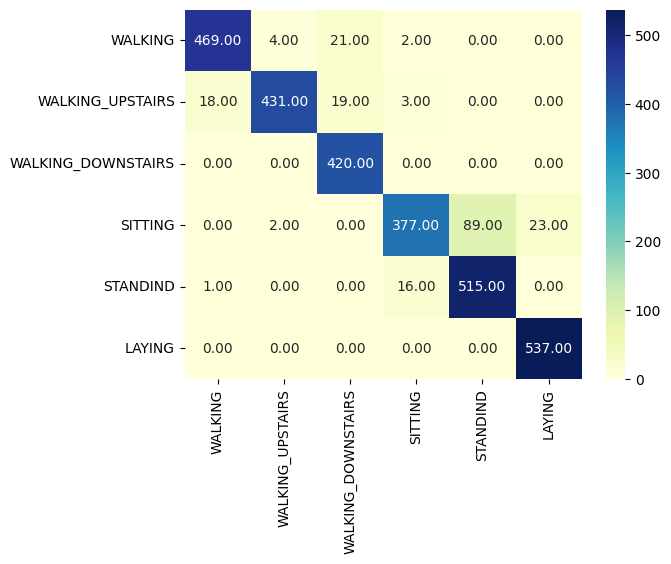

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM1 - BiGRU2 </h1>

In [20]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 16s 104ms/step - loss: 1.0910 - accuracy: 0.5389 - val_loss: 0.8365 - val_accuracy: 0.6269
Epoch 2/100
58/58 [==============================] - 4s 62ms/step - loss: 0.6573 - accuracy: 0.7069 - val_loss: 0.5367 - val_accuracy: 0.7629
Epoch 3/100
58/58 [==============================] - 4s 69ms/step - loss: 0.4597 - accuracy: 0.8090 - val_loss: 0.3877 - val_accuracy: 0.8649
Epoch 4/100
58/58 [==============================] - 4s 63ms/step - loss: 0.2641 - accuracy: 0.8995 - val_loss: 0.1698 - val_accuracy: 0.9279
Epoch 5/100
58/58 [==============================] - 4s 64ms/step - loss: 0.1825 - accuracy: 0.9312 - val_loss: 0.1453 - val_accuracy: 0.9474
Epoch 6/100
58/58 [==============================] - 4s 69ms/step - loss: 0.1454 - accuracy: 0.9399 - val_loss: 0.1728 - val_accuracy: 0.9238
Epoch 7/100
58/58 [==============================] - 4s 65ms/step - loss: 0.1510 - accuracy: 0.9378 - val_loss: 0.1217 - val_accuracy: 0.9402
Epoc

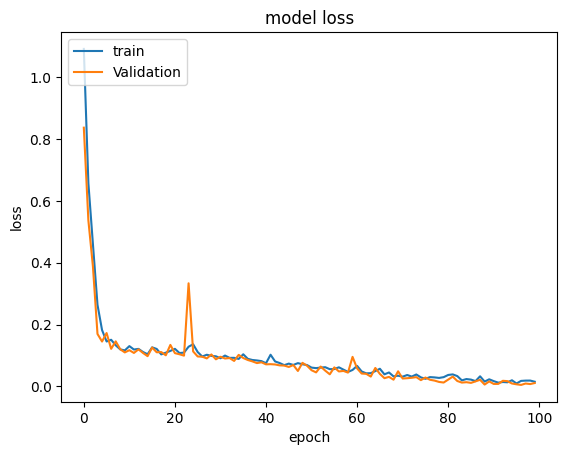

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

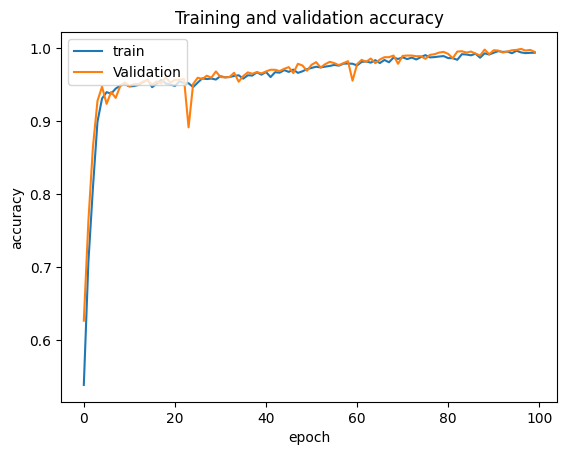

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 14ms/step
[[465   0  21   2   8   0]
 [  2 444  22   3   0   0]
 [  0   0 420   0   0   0]
 [  0  19   0 378  89   5]
 [  0   0   0  20 512   0]
 [  0  27   0   0   0 510]]
0.9260264675941635
0.9253793905478648
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.91      0.94      0.92       471
           2       0.91      1.00      0.95       420
           3       0.94      0.77      0.85       491
           4       0.84      0.96      0.90       532
           5       0.99      0.95      0.97       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

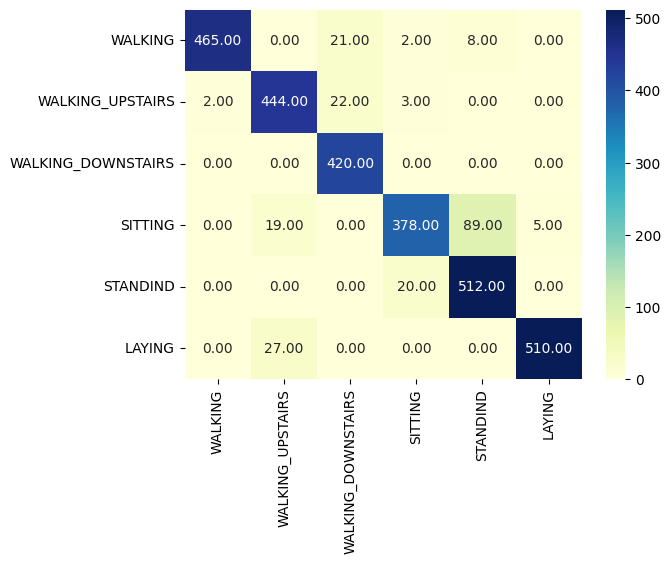

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU2 </h1>

In [25]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_10 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                      

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 21s 137ms/step - loss: 1.0804 - accuracy: 0.5413 - val_loss: 0.7213 - val_accuracy: 0.7076
Epoch 2/100
58/58 [==============================] - 5s 85ms/step - loss: 0.5892 - accuracy: 0.7737 - val_loss: 0.4062 - val_accuracy: 0.8490
Epoch 3/100
58/58 [==============================] - 5s 87ms/step - loss: 0.3508 - accuracy: 0.8698 - val_loss: 0.2386 - val_accuracy: 0.9062
Epoch 4/100
58/58 [==============================] - 5s 88ms/step - loss: 0.2430 - accuracy: 0.9178 - val_loss: 0.1804 - val_accuracy: 0.9306
Epoch 5/100
58/58 [==============================] - 5s 85ms/step - loss: 0.1610 - accuracy: 0.9393 - val_loss: 0.1820 - val_accuracy: 0.9415
Epoch 6/100
58/58 [==============================] - 5s 86ms/step - loss: 0.1633 - accuracy: 0.9374 - val_loss: 0.1783 - val_accuracy: 0.9297
Epoch 7/100
58/58 [==============================] - 5s 86ms/step - loss: 0.1682 - accuracy: 0.9319 - val_loss: 0.1201 - val_accuracy: 0.9474
Epoc

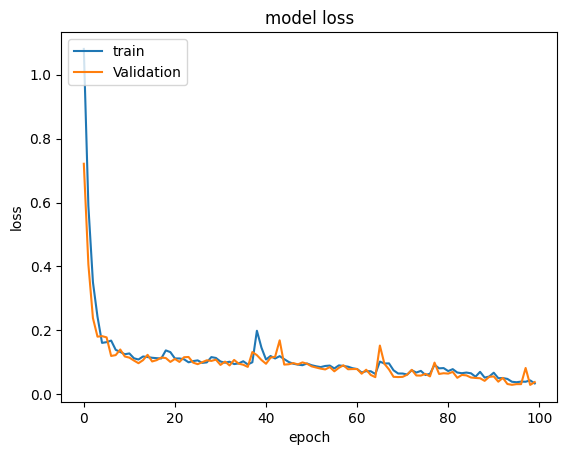

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

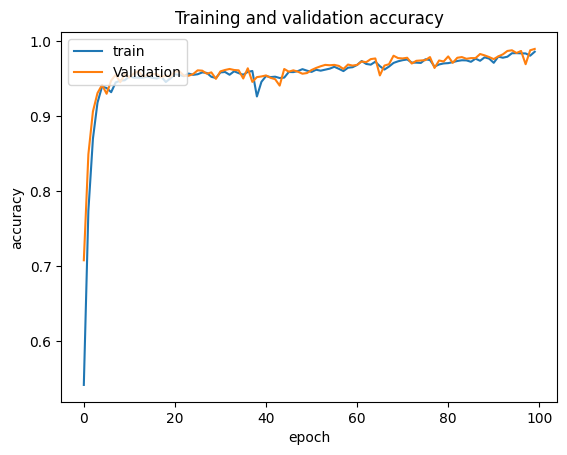

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 16ms/step
[[470   1  25   0   0   0]
 [ 11 444  16   0   0   0]
 [  0   0 420   0   0   0]
 [  0   3   0 386  96   6]
 [  0   0   0  34 498   0]
 [  0   0   0   0   0 537]]
0.9348489989820156
0.9343268433769141
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.99      0.94      0.97       471
           2       0.91      1.00      0.95       420
           3       0.92      0.79      0.85       491
           4       0.84      0.94      0.88       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.94      0.94      0.93      2947
weighted avg       0.94      0.93      0.93      2947



<Axes: >

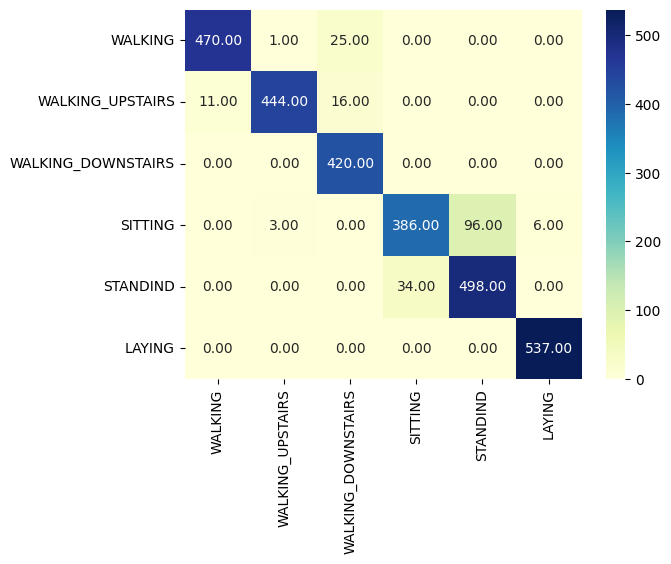

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU2 (Crossed)</h1>

In [30]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 128, 256)          141312    
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_13 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_14 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                      

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 21s 137ms/step - loss: 1.0269 - accuracy: 0.5721 - val_loss: 0.6923 - val_accuracy: 0.7040
Epoch 2/100
58/58 [==============================] - 5s 88ms/step - loss: 0.5443 - accuracy: 0.7922 - val_loss: 0.5449 - val_accuracy: 0.8073
Epoch 3/100
58/58 [==============================] - 5s 85ms/step - loss: 0.3673 - accuracy: 0.8706 - val_loss: 0.2473 - val_accuracy: 0.9125
Epoch 4/100
58/58 [==============================] - 5s 85ms/step - loss: 0.3367 - accuracy: 0.8784 - val_loss: 0.2184 - val_accuracy: 0.9202
Epoch 5/100
58/58 [==============================] - 5s 86ms/step - loss: 0.1842 - accuracy: 0.9294 - val_loss: 0.1343 - val_accuracy: 0.9402
Epoch 6/100
58/58 [==============================] - 5s 88ms/step - loss: 0.1655 - accuracy: 0.9370 - val_loss: 0.1489 - val_accuracy: 0.9429
Epoch 7/100
58/58 [==============================] - 5s 87ms/step - loss: 0.1520 - accuracy: 0.9404 - val_loss: 0.1276 - val_accuracy: 0.9524
Epoc

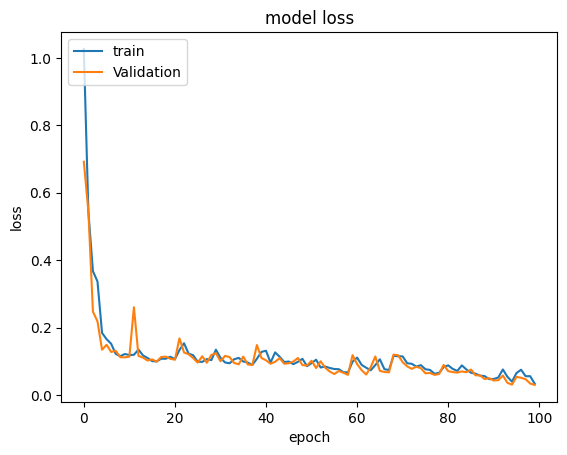

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

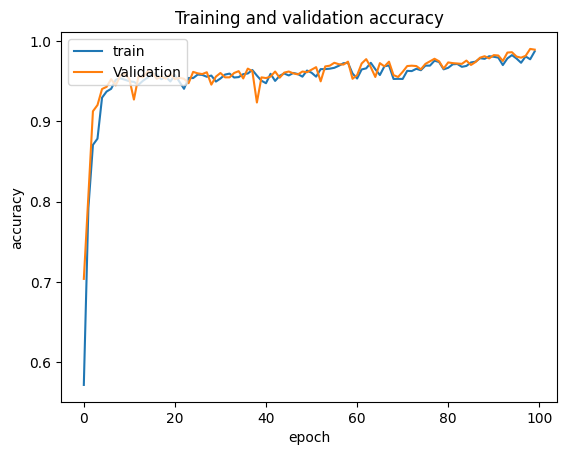

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 17ms/step
[[467   0  28   1   0   0]
 [ 12 456   1   2   0   0]
 [ 12   2 406   0   0   0]
 [  0   2   0 370 108  11]
 [  1   0   0  36 495   0]
 [  0   0   0   0   0 537]]
0.9267051238547676
0.9258424669542349
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       496
           1       0.99      0.97      0.98       471
           2       0.93      0.97      0.95       420
           3       0.90      0.75      0.82       491
           4       0.82      0.93      0.87       532
           5       0.98      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

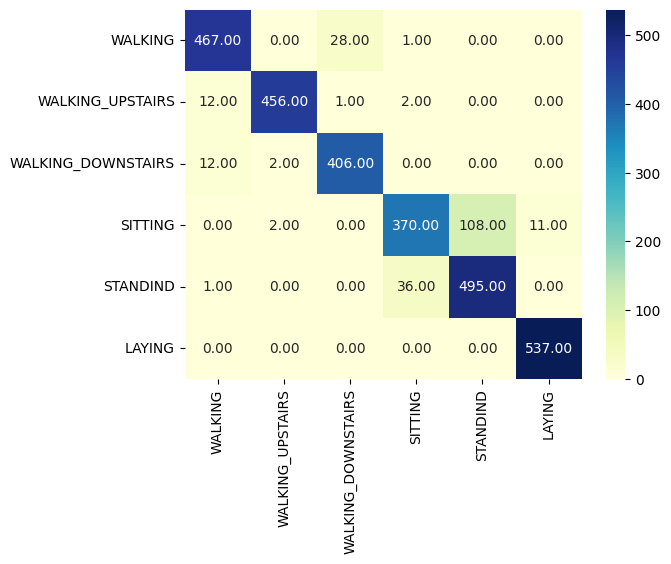

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM3 - BiGRU3 </h1>

In [35]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirect  (None, 128, 256)          141312    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_17 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_18 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                      

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 32s 210ms/step - loss: 1.1017 - accuracy: 0.5226 - val_loss: 0.6889 - val_accuracy: 0.7094
Epoch 2/10
58/58 [==============================] - 8s 139ms/step - loss: 0.5361 - accuracy: 0.7905 - val_loss: 0.5869 - val_accuracy: 0.8187
Epoch 3/10
58/58 [==============================] - 8s 140ms/step - loss: 0.3056 - accuracy: 0.8901 - val_loss: 0.1864 - val_accuracy: 0.9374
Epoch 4/10
58/58 [==============================] - 8s 131ms/step - loss: 0.1936 - accuracy: 0.9270 - val_loss: 0.1467 - val_accuracy: 0.9447
Epoch 5/10
58/58 [==============================] - 8s 131ms/step - loss: 0.1519 - accuracy: 0.9419 - val_loss: 0.1300 - val_accuracy: 0.9538
Epoch 6/10
58/58 [==============================] - 8s 140ms/step - loss: 0.1354 - accuracy: 0.9480 - val_loss: 0.2237 - val_accuracy: 0.9329
Epoch 7/10
58/58 [==============================] - 8s 132ms/step - loss: 0.1471 - accuracy: 0.9426 - val_loss: 0.1206 - val_accuracy: 0.9547
Epoch

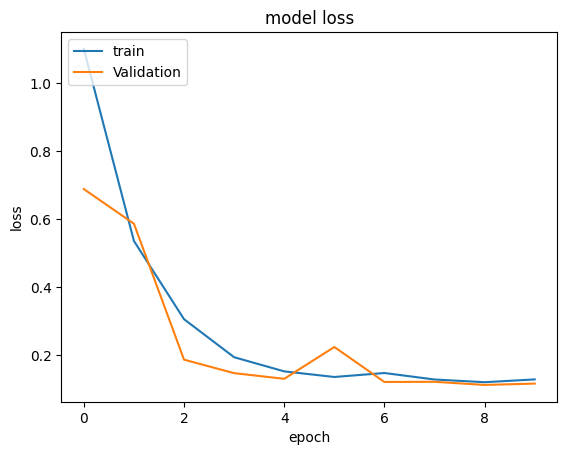

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

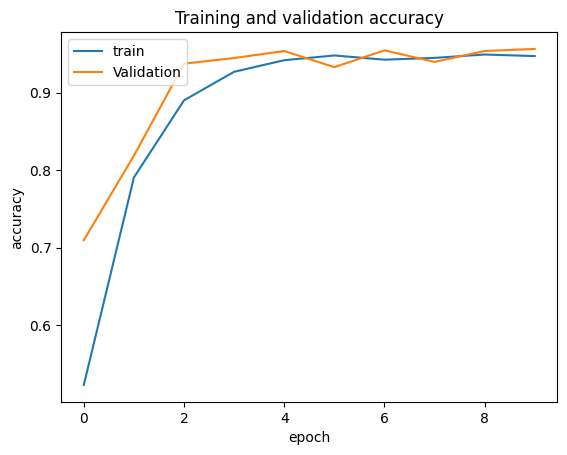

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 7s 33ms/step
[[460   5  31   0   0   0]
 [ 16 417  38   0   0   0]
 [  7   0 413   0   0   0]
 [  0  18   0 397  68   8]
 [  1   1   0 114 416   0]
 [  0   0   0   0   0 537]]
0.8958262639972854
0.895392160905562
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       496
           1       0.95      0.89      0.91       471
           2       0.86      0.98      0.92       420
           3       0.78      0.81      0.79       491
           4       0.86      0.78      0.82       532
           5       0.99      1.00      0.99       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

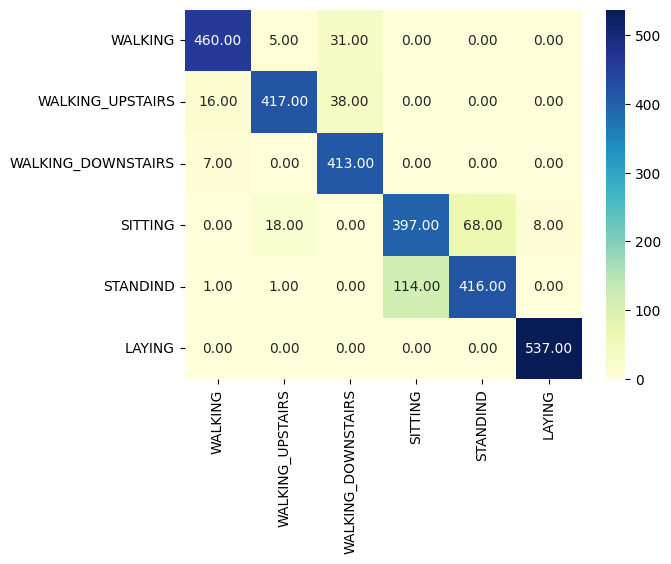

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')